<a href="https://colab.research.google.com/github/anisalopezruiz/bio108tutorial/blob/main/Bee_community_composition_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bee habitat and community structure

In this tutorial, we will analyze a dataset published by [Larson et al. 2024](https://onlinelibrary.wiley.com/doi/10.1002/ece3.70719). This data is includes the bee community structure recorded at four national parks in the mid-Atlantic.


![Figure from Larson et al. 2024](https://onlinelibrary.wiley.com/cms/asset/390ae01e-5095-47a2-abed-8a027146d815/ece370719-fig-0001-m.jpg)


This study focuses on floral resources and native bees in grasslands managed by the National Park Service in the mid-Atlantic region. They compared the floral resources and native bees across three types of habitat management: warm season meadows (WSM), cool season pastures (CSP) and cool season hayfields (CSH). Their goal was to determine whether bee and plant communities differed across the management groups.

In the following tutorial, we will analyze the bee community data to determine whether they differ across management groups.

# Our analysis
### Question
Does bee community composition differ across mangement groups?

### Analytical approach
We will use principal component analysis (PCA). Principal component analysis reduces the dimensionality of data, in this case, the types of species, the abundance of each species, etc.

# Data and library imports

Let's start with importing all the libraries we will need for the analysis.

In [ ]:
# imports
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# specific imports
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from matplotlib.colors import to_rgba

# magic function to force plots to display inline
%matplotlib inline

Now we can import the data itself. The data is [directly available](https://www.sciencebase.gov/catalog/item/66c6021ad34e0338828a6594) from USGS. However, for ease of use, I uploaded the data to a [Github repository](https://github.com/anisalopezruiz/bio108tutorial/raw/refs/heads/main/data/BattlefieldBees_2021_2022_final_v2.csv), which we will use here.

In [ ]:
# Storing the github url for the raw data download
url = 'https://github.com/anisalopezruiz/bio108tutorial/raw/refs/heads/main/data/BattlefieldBees_2021_2022_final_v2.csv'

# use read excel function because this is a .xlsx file
bee = pd.read_csv(url)

# Data preprocessing

Let's take a look at our dataset to see how we should modify it to input into a PCA analysis.

In [ ]:
bee[:10]

,field_ID,bee_species,sex,park,transect_ID,method,date,type,taxonomy_notes
0,CHOH 1_3,Andrena,m,CHOH,T216,pan trap,5/23/2022,cool season-hay,Andrena sp.
1,ANTI 11,Andrena,f,ANTI,T21,pan trap,5/26/2022,cool season-hay,Andrena sp. (imitatrix/morrisonella)
2,ANTI 11,Andrena,f,ANTI,T21,pan trap,5/26/2022,cool season-hay,Andrena sp. (imitatrix/morrisonella)
3,ANTI 11,Andrena,f,ANTI,T21,pan trap,5/26/2022,cool season-hay,Andrena sp. (imitatrix/morrisonella)
4,ANTI 11,Andrena,f,ANTI,T21,pan trap,5/26/2022,cool season-hay,Andrena sp. (imitatrix/morrisonella)
5,ANTI 21,Andrena,f,ANTI,T167,pan trap,5/25/2022,cool season-hay,Andrena sp. (imitatrix/morrisonella)
6,ANTI 21,Andrena,f,ANTI,T167,pan trap,5/25/2022,cool season-hay,Andrena sp. (imitatrix/morrisonella)
7,ANTI 21,Andrena,f,ANTI,T167,pan trap,5/25/2022,cool season-hay,Andrena sp. (imitatrix/morrisonella)
8,ANTI 21,Andrena,f,ANTI,T167,pan trap,5/25/2022,cool season-hay,Andrena sp. (imitatrix/morrisonella)
9,ANTI 33,Andrena,f,ANTI,T20,pan trap,6/8/2022,warm season-multi,Andrena sp. (imitatrix/morrisonella)


We see that each row in the dataframe represents a bee. This includes a unique field ID, sex of the bee, the park, date of sample, habitat type, and notes on taxonomy.

For PCA, we want to group the community composition of each site in a row. Our data will be presence/absence.

![](https://raw.githubusercontent.com/anisalopezruiz/bio108tutorial/refs/heads/main/Tutorial/presenceAbsence.png)

That means, for the rows, we want to have the unique field id. For the columns, we want to have all the species of bees observed. For each row, we will have either a 1, meaning the bee is present in the field, or 0, meaning the bee is absent in the field.

In [ ]:
# select all the unique bee species values, which represents all the bee species observed
species = bee['bee_species'].unique()

# create a data frame with columns representing the bee species observed
# all these cells have a value of NaN
bee_df = pd.DataFrame(columns=species)

# let's add a column that represents the unique field IDs
bee_df.insert(0, 'field_id', bee['field_ID'].unique())

Now, we will use the groupby function in order to match the field id to all the bee species observed in that particular field

In [ ]:
# use the groupby function to match the field ID to its bee species
# unique() makes sure that bee species values aren't represented multiple times
unique_bees = bee.groupby('field_ID')['bee_species']

In [ ]:
unique_bees.get_group('ANTI 21')

,bee_species
5,Andrena
6,Andrena
7,Andrena
8,Andrena
59,Halictus
...,...
5921,Melissodes desponsus
5922,Melissodes desponsus
5923,Melissodes desponsus
5924,Melissodes desponsus


We want to match the bee species to the bee dataframe.

unique_bees has a list of all the unique bee species matched to a particular row.

We want to go through each row in bee_df, which contains the unique field IDs.

Then, we will grab the list of unique species for that given row from unique_bees.

Finally, we will change the value in bee_df to 1 for that unique field ID and bee species.

This results in a dataframe where the bees are marked as 1 if they are present in a particular field ID.

In [ ]:
# go through each row in bee_df
for index, row in bee_df.iterrows():
  # grab the unique list of species from unique_bees
  key = unique_bees[row.field_id]
  # go through the unique list of species
  for species in key:
    # assign a value of 1 where the bee is present
    bee_df.at[index, species] = 1

In [ ]:
# let's double check that we filled in the correct values
bee_df.head()

,field_id,Andrena,Halictus,Heriades,Hylaeus,Lasioglossum,Megachile,Nomada,Agapostemon texanus,Agapostemon virescens,...,Osmia bucephala,Osmia georgica,Osmia pumila,Osmia subfasciata,Peponapis pruinosa,Perdita boltoniae,Ptilothrix bombiformis,Sphecodes heraclei,Svastra obliqua,Xylocopa virginica
0,CHOH 1_3,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,ANTI 11,1,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,ANTI 21,1,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,ANTI 33,1,1,0,1,1,0,0,0,1,...,1,0,0,0,0,0,1,0,1,1
4,CHOH 0,1,1,1,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1


Our dataframe looks good!

Let's change all the NaN values to 0 to get it ready for our PCA.

In [ ]:
# change NaN value in the dataframe to 0
bee_df = bee_df.fillna(0)
bee_df.head()

,field_id,Andrena,Halictus,Heriades,Hylaeus,Lasioglossum,Megachile,Nomada,Agapostemon texanus,Agapostemon virescens,...,Osmia bucephala,Osmia georgica,Osmia pumila,Osmia subfasciata,Peponapis pruinosa,Perdita boltoniae,Ptilothrix bombiformis,Sphecodes heraclei,Svastra obliqua,Xylocopa virginica
0,CHOH 1_3,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,ANTI 11,1,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,ANTI 21,1,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,ANTI 33,1,1,0,1,1,0,0,0,1,...,1,0,0,0,0,0,1,0,1,1
4,CHOH 0,1,1,1,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1


Our data is now ready for the PCA model! 😀

# Data analysis

Now, we will use our data to fit a PCA model.

The PCA model only uses numeric data. The field_id column is a string, so we cannot input it in the model.

In [ ]:
# drop the field_id column for the data we will input in our PCA
x_bee = bee_df.drop('field_id', axis=1)

Now, we can fit the PCA.

In [ ]:
# instantiate a PCA model with 2 components
model = PCA(n_components=2)
# fit the data
model.fit(x_bee)
X_2D = model.transform(x_bee)

One last thing!! We want to shade the values depending on the type of management the field is subject to.

We have to go back and use the group_by function to match the field IDs to the type of habitat management.

In [ ]:
# match the field ID to the type of habitat management
mngmt_type = bee.groupby('field_ID')['type'].unique()

In [ ]:
# change the object to a dataframe for ease of use
mngmt_df = mngmt_type.to_frame()

The 'type' column in our dataframe is formatted in an unconventional way that will not work when we try to plot our model.

We will change the type to a simple string, depending on what the mangement type is.

In [ ]:
mngmt_df.loc[mngmt_df['type'] == 'cool season-pasture', 'type'] = 'CSP'
mngmt_df.loc[mngmt_df['type'] == 'cool season-hay', 'type'] = 'CSH'
mngmt_df.loc[mngmt_df['type'] == 'warm season-multi', 'type'] = 'WSM'

Now, we can merge the two dataframes: our community composition bee_df dataframe and the management type dataframe.

We can merge these because both dataframes contain a field_id column.

In [ ]:
# merge the dataframes
# this will add a 'type' column with either CSP, CSH, or WSM to  bee_df
bee_df = bee_df.merge(mngmt_df, left_on='field_id', right_on='field_ID')

Let's add the PCA analyses components to new columns in bee_df.

We will plot the PCA based on these components.

Our hue is the 'type' column, which is the management type we just added to bee_df.

In [ ]:
bee_df['PCA1'] = X_2D[:, 0]
bee_df['PCA2'] = X_2D[:, 1]

### Plot the PCA analysis

We have to now plot the PCA analysis.

In addition to plotting the individual points representing each site, we also want to plot convex hulls. This will fit a polygon around the points.

![](https://cdn-images-1.medium.com/v2/resize:fit:1200/1*F4IUmOJbbLMJiTgHxpoc7Q.png)

This way, we can visualize the overlap between the polygons representing the three different habitat types.

We will first set unique colors for each habitat type.

In [ ]:
# Get the unique values of type, which are CSH, WSM and CSP
hues = bee_df["type"].unique()

# We can set the colors using the Paired color palette
colors = sns.color_palette("Paired", len(hues))
palette = {hue_val: color for hue_val, color in zip(hues, colors)}

We will define a function to create a convex hull that is shaded inside, for better visualization.

In [ ]:
def overlay_cv_hull_dataframe(x, y, color, data, hue):
    # Get the Convex Hull for each group based on hue
    for hue_val, group in data.groupby(hue):
        hue_color = palette[hue_val]
        points = group[[x, y]].values
        # ConvexHull creates the convey hull
        hull = ConvexHull(points)
        # fill the convex hull with the specific color
        plt.fill(points[hull.vertices, 0], points[hull.vertices, 1],
                 facecolor=to_rgba(hue_color, 0.2),
                 edgecolor=hue_color)

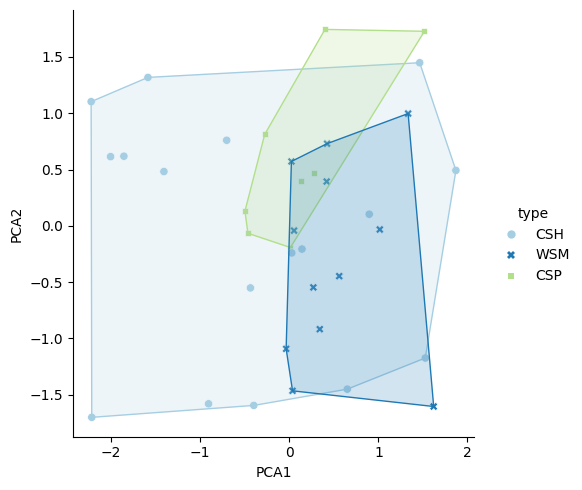

In [ ]:
# instantiate Seaborn plot and display the individual points as a scatter plot
g = sns.relplot(data=bee_df, x='PCA1', y='PCA2',
                hue="type", style="type", palette=palette, kind='scatter')

# Plot the convey hulls
g.map_dataframe(overlay_cv_hull_dataframe, x='PCA1', y='PCA2', hue='type')

# set the axes labels
g.set_axis_labels('PCA1', 'PCA2')

plt.show()

We see that the community compositions of each management type overlap; the convex hulls are not clearly differentiated.

This means even with different types of management producing different habitats, bee communities do not differ.

Great job on completing the tutorial!

![](https://kajabi-storefronts-production.kajabi-cdn.com/kajabi-storefronts-production/sites/180478/images/XWrkE5qvRrSXOgE5dUkK_file.jpg)